In [25]:
##imports
import numpy as np ##used for array math
import matplotlib.pyplot as plt ##used for plotting different views and seams
import imageio.v2 as imageio ## we need this for image read and write
from PIL import Image
import os


In [ ]:
##required functions
# First we need to calcualte the energy map of input image
# to do this we calculate the gradient in both x and y directions
# sobel operator 3 x 3 matric that is applied to image to calculate gradient
# then we use gradient at a cell to calcualte magnitude as sqrt(gx^2 + gy^2)
# Penalize borders so seams don't hug the edges



#a custom function to help prevent the seams from sticking to the sides 
def add_edge_penalty(energy, penalty_strength=10.0): #We use this function to basically make the sides high energy so the algorithm doesnt like them 
  M, N = energy.shape # we need the energy shape for this ofcourse 
  
  # Calculate adaptive edge width based on image size
  edge_width = max(5, int(0.015 * min(M, N)))  #a max of 5 pixels for edge width or 1.5% of the smaller dimension
  # Calculate mean energy for scaling (more stable than max)
  mean_energy = np.mean(energy)
  if mean_energy == 0: #base case make sure we have more than 0
    mean_energy = 1.0
  
  # Create coordinate grids X = N and Y = M
  x = np.arange(N)
  y = np.arange(M)
  X, Y = np.meshgrid(x, y) #both create a meshgrid
  
  # Calculate distance from each edge for each pixel. the closer it is to the edge the higher the penalty
  dist_from_left = X #
  dist_from_right = N - 1 - X 
  dist_from_top = Y
  dist_from_bottom = M - 1 - Y
  
  # we need this to calculate The penalty strength which should be strongest right at any border and decay smoothly
  dist_from_edge = np.minimum(
    np.minimum(dist_from_left, dist_from_right),
    np.minimum(dist_from_top, dist_from_bottom)
  )
  
  # Create smooth penalty using exp decay 
  penalty_map = np.zeros_like(energy)
  mask = dist_from_edge < edge_width
  
  #  penalty = strength * exp(-alpha * distance)
  alpha = 3.0 / edge_width  # Decay to 5% at edge_width
  penalty_map[mask] = penalty_strength * mean_energy * np.exp(-alpha * dist_from_edge[mask]) #this is the penalty
   
  return energy + penalty_map #return the new energy map with the added energy on the sides



def find_energy(image):
  assert image.ndim == 3 and image.shape[2] == 3 ##checking that the image has all info we need RGB and M X N
  imf = image.astype(np.float64)/255.0 # normalizing values of the image
  #now we make it grey
  grey = (0.299 * imf[...,0] + 0.587 * imf[...,1] + 0.114 * imf[...,2]) ##multiplying each color R G B by standard luminance formula to get grey scale image
  gy, gx = np.gradient(grey) #calculating the gradiennt of the image using numpy
  energy = np.sqrt (gx*gx + gy*gy) ##setting the energy to the sqrt of gx^2 +gy^2
  
  # Add improved edge penalty to prevent seams from sticking to boundaries
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  
  return energy.astype(np.float64) ## returning the enery map as a float to maintain accruacy

##fOR Task 5 using Sobel but we implement the filtering ourselves no libraries
def _pad_reflect(img, ph, pw):
  return np.pad(img, ((ph, ph), (pw, pw)), mode='reflect')  ##reflect padding so borders dont get weird and because its built in and easy

def _conv2d_same(gray, kernel):
  kh, kw = kernel.shape              ##read in the kernal size which is 3x3 for sobel
  ph, pw = kh//2, kw//2              ##half sizes so we can keep same output size
  padded = _pad_reflect(gray, ph, pw) #for areas outside the bounds we pad with reflect to ensure proper input 
  H, W = gray.shape #we take in the original image size to make sure the output is the same size
  out = np.zeros_like(gray, dtype=np.float64) #setting the output array 
  k = np.flipud(np.fliplr(kernel))   ##flipping to go from correlation to convolution
  for i in range(H):                 ##for every x and y slide the 3x3 window aaround every pixel
    for j in range(W):
      patch = padded[i:i+kh, j:j+kw] ##Store that padded window as patch 
      out[i, j] = np.sum(patch * k)  ##dot product of both gives us the filtered value 
  return out

def find_energy_sobel(image):
  assert image.ndim == 3 and image.shape[2] == 3  ##must be color MxNx3
  imf = image.astype(np.float64)/255.0            ##normalize to floats
  ##make it grey with standard luminance weights from pdf
  grey = (0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2])

  ##Define Sobel kernels (x detects left↔right changes, y detects up↕down)
  sobel_x = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]], dtype=np.float64)
  sobel_y = np.array([[-1,-2,-1],
                      [ 0, 0, 0],
                      [ 1, 2, 1]], dtype=np.float64)

  ##call our mangual conf24 function to get gradients
  gx = _conv2d_same(grey, sobel_x)
  gy = _conv2d_same(grey, sobel_y)

  ##energy is magnitude sqrt(gx^2 + gy^2) same as before
  energy = np.sqrt(gx*gx + gy*gy)
  
  # Add improved edge penalty to prevent seams from sticking to boundaries
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  
  return energy.astype(np.float64)


def find_energy_prewitt(image):
  assert image.ndim == 3 and image.shape[2] == 3  ##must be color MxNx3
  imf = image.astype(np.float64)/255.0            ##normalize to floats
  ##make it grey with standard luminance weights
  grey = (0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2])

  ##Define Prewitt kernels (simpler than Sobel, all weights are ±1)
  prewitt_x = np.array([[-1, 0, 1],
                        [-1, 0, 1], 
                        [-1, 0, 1]], dtype=np.float64) #our vertical filter for finding standing lines
  prewitt_y = np.array([[-1,-1,-1],
                        [ 0, 0, 0], ##asigning negative for the top and positive for the bottom
                        [ 1, 1, 1]], dtype=np.float64)#our horizontal filter for finding horizontal lines
  ##these two helps us find vertical and horizontal gradients 

  ##apply our manual conv  filters that we just made to get gradients
  gx = _conv2d_same(grey, prewitt_x)
  gy = _conv2d_same(grey, prewitt_y)

  ##energy is magnitude sqrt(gx^2 + gy^2) same as before 
  energy = np.sqrt(gx*gx + gy*gy)
  
  # Add  edge penalty to prevent seams from sticking to boundaries
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  
  return energy.astype(np.float64)
## we must implement a dynamic method to find the vertical and horizontal seams that is in the paper and in class
##Each Verical we must add the Cells min of three parents from the previous row.
def Cumulative_min_energy_map(energyImg, SD):  ##seamdirection
  assert energyImg.ndim == 2 ## checking if the image is actually greyscale
  dir_up = SD.upper() ##setting the direction to whatever string we got in either "Horizontal or Vertical"

  if dir_up == 'VERTICAL':
    M, N = energyImg.shape ##take in the number of rows and columns
    Cumulative = np.zeros_like(energyImg, dtype=np.float64 ) ##create a new vector so that we can store the energy of the whole seam isntead of just one pixel to find the best seam
    Cumulative[0] = energyImg[0] ##starting the energy as just the energy for that first cell at the top
    ##then for the rest of the seam
    for i in range(1,M):
      ## we want to set the three parent pixels then choose the best and continue
      left = np.r_[np.inf, Cumulative[i-1, :-1]] ## the left parents is up to the left
      up = Cumulative[i-1] ##directly above
      right =np.r_[Cumulative[i-1, 1:],np.inf] #up to the right parent
      #find the best parent
      best = np.minimum(np.minimum(left, up), right) ##double np.minimum or diffrence of three parents 
      Cumulative[i] = energyImg[i] +best ##add the energy of the current cell to the best parent
    return Cumulative #the total energy of the seam with the minimal energy 

  ## now we want direction checks to specify vertical or horizontal seams
  if dir_up == 'HORIZONTAL':
    return Cumulative_min_energy_map(energyImg.T, 'VERTICAL').T
  ##if we need to switch we use trnaspose which swaps rows andf columns
  raise ValueError("Direction must be 'VERTICAL' or 'HORIZONTAL'")


def find_vertical_seam(CumulativeEnergyMap):
  M ,N = CumulativeEnergyMap.shape
  seam = np.zeros(M, dtype=np.int32) ##array to hold the same pixels
  seam[-1] = int(np.argmin(CumulativeEnergyMap[-1])) #find the cheapest path starting from the bottom total energy row
  for i in range(M-2, -1, -1):
    j = seam[i+1]#only checking cell above
    j_left = max(j-1, 0)  ##checking cell to the left clamping at 0 max
    j_right = min(j+1, N-1) ##checking cell to right clamping n-1
    window = CumulativeEnergyMap[i, j_left:j_right+1] ##finding the cost of the 2-3 parents above so we can pick the cheapest
    seam[i] = j_left + int(np.argmin(window)) #finding the lowest energy cell from the columns to choose for the seam location per row
  return seam #update the seam


def find_horizontal_seam(CumulativeEnergyMap): #transposing for horizontal seams so again switching M and N
  return find_vertical_seam(CumulativeEnergyMap.T).astype(np.int32)


#Now we can do some actual carving
def decrease_width(image, energyImg_in): #this function will cut vertical seams 
  Cumulative = Cumulative_min_energy_map(energyImg_in, 'VERTICAL')  #getting the cumulative vertical energy map and saving into cumulative 
  seam = find_vertical_seam(Cumulative) #calling the find vertical seasm function with the energy map to find the seam
  M, N, _ = image.shape #getting the shape of the image and saving into height and width ignoring the 3rd dimension
  out = np.zeros((M, N-1, 3), dtype=image.dtype) #creating the new image with that one less column
  for i in range(M): #now we want to remove each cell or pixel 
    j = seam[i] #the column we want to remove
    out[i, :, :] = np.delete(image[i, :, :], j, axis=0) #    # Delete along axis=0 to remove the j column in this row.

  new_energy = find_energy(out)   ##recompute once after we finish removing the column
  return out, new_energy
 ##the new picture and the new calculated energy that theorettically should be lower
 # removing one horizontal seam (height shrinks by 1)
def decrease_height(image, energyImg_in):
  Cumulative = Cumulative_min_energy_map(energyImg_in, 'HORIZONTAL')  ##finding horizontal energy 
  seam = find_horizontal_seam(Cumulative)##finding the horizontal seam
  M, N, _ = image.shape #getting original height and width
  out = np.zeros((M-1, N, 3), dtype=image.dtype)#allocating with one less row 
  for j in range(N):                 ##for chosen row delete every cell
    i = seam[j] #for this row we delete this seam of cells
    out[:, j, :] = np.delete(image[:, j, :], i, axis=0) #delete each
  new_energy = find_energy(out) ##new energy 
  return out, new_energy
  # show the chosen seam on top of an image (for plots)

def view_seam(im, seam, seamDirection): #as specified in pdf we need a function to view the seams 
  dir_up = seamDirection.upper() #normalziingn to uppercase 
  plt.imshow(im) #using plot to show the image with the seam on it 
  if dir_up == 'VERTICAL': #if its vertical 
    plt.plot(seam, np.arange(len(seam)), 'r-')   ##x=cols, y=rows ##show as red
  elif dir_up == 'HORIZONTAL':
    plt.plot(np.arange(len(seam)), seam, 'b-')   ##x=cols, y=rows ##show as b
  else: 
    raise ValueError("Direction must be 'VERTICAL' or 'HORIZONTAL'")
  plt.axis('off'); plt.show()

  ##task 5 code
  # ---- manual 2D convolution (sliding window) with reflect padding ----
def _pad_reflect(arr, ph, pw):
    return np.pad(arr, ((ph, ph), (pw, pw)), mode='reflect')

def conv2d_same(gray: np.ndarray, kernel: np.ndarray) -> np.ndarray: ##function to apply conv manually either prewitt or sobel 
    kh, kw = kernel.shape ##kernel size always a 3 x3 
    ph, pw = kh//2, kw//2 ##padding size which is half kernal size 
    padded = _pad_reflect(gray, ph, pw) #store padded as the padded image 
    out = np.zeros_like(gray, dtype=np.float64) ##alocating space for the output image
    for i in range(gray.shape[0]): ##for every x and y slide the 3x3 window aaround every pixel
        for j in range(gray.shape[1]): 
            window = padded[i:i+kh, j:j+kw] ##store the window
            out[i, j] = float(np.sum(window * kernel)) #multiply the window by the kernal then sum then thats the colvolution result 
    return out

# ---- custom energy: Prewitt + directional prior (boost vertical edges) ----
def energy_img_prewitt_custom(im: np.ndarray, w_vert: float = 1.25, w_horz: float = 1.0, apply_edge_penalty: bool = True) -> np.ndarray:
    if im.dtype != np.uint8 or im.ndim != 3 or im.shape[2] != 3:
        raise ValueError("im must be MxNx3 uint8")
    imf = im.astype(np.float64) / 255.0
    gray = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
    # Prewitt kernels
    kx = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]], dtype=np.float64)
    ky = np.array([[-1, -1, -1],
                   [ 0,  0,  0],
                   [ 1,  1,  1]], dtype=np.float64)
    gx = conv2d_same(gray, kx)
    gy = conv2d_same(gray, ky)
    energy = np.hypot(w_vert*gx, w_horz*gy)
    
    # Add edge penalty to prevent seams from sticking to boundaries
    if apply_edge_penalty:
        energy = add_edge_penalty(energy, penalty_strength=10.0)
    
    return energy.astype(np.float64)

# ---- local cumulative maps (kept here so this cell is self-contained) ----
def cumulative_min_energy_map_local(energyImg: np.ndarray, seamDirection: str) -> np.ndarray:
    seamDirection = seamDirection.upper()
    M, N = energyImg.shape
    cu = energyImg.astype(np.float64).copy()
    if seamDirection == 'VERTICAL':
        for i in range(1, M):
            prev = cu[i-1]
            for j in range(N):
                m = prev[j]
                if j > 0:   m = min(m, prev[j-1])
                if j < N-1: m = min(m, prev[j+1])
                cu[i, j] += m
    elif seamDirection == 'HORIZONTAL':
        for j in range(1, N):
            prev = cu[:, j-1]
            for i in range(M):
                m = prev[i]
                if i > 0:    m = min(m, prev[i-1])
                if i < M-1:  m = min(m, prev[i+1])
                cu[i, j] += m
    else:
        raise ValueError("seamDirection must be 'VERTICAL' or 'HORIZONTAL'")
    return cu

def _find_vertical_seam_from(cum: np.ndarray) -> np.ndarray:
    M, N = cum.shape
    seam = np.zeros(M, dtype=np.int64)
    seam[-1] = int(np.argmin(cum[-1]))
    for i in range(M-2, -1, -1):
        j = seam[i+1]
        candidates = [j]
        if j > 0:     candidates.append(j-1)
        if j < N-1:   candidates.append(j+1)
        seam[i] = min(candidates, key=lambda c: cum[i, c])
    return seam

def _find_horizontal_seam_from(cum: np.ndarray) -> np.ndarray:
    M, N = cum.shape
    seam = np.zeros(N, dtype=np.int64)
    seam[-1] = int(np.argmin(cum[:, -1]))
    for j in range(N-2, -1, -1):
        i = seam[j+1]
        candidates = [i]
        if i > 0:     candidates.append(i-1)
        if i < M-1:   candidates.append(i+1)
        seam[j] = min(candidates, key=lambda r: cum[r, j])
    return seam



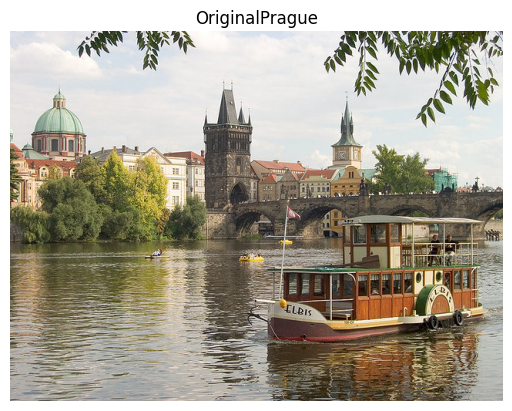

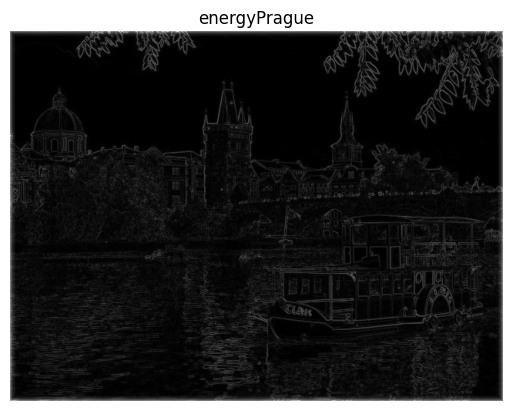

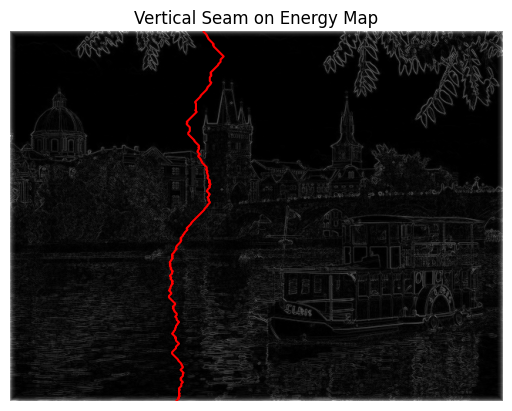

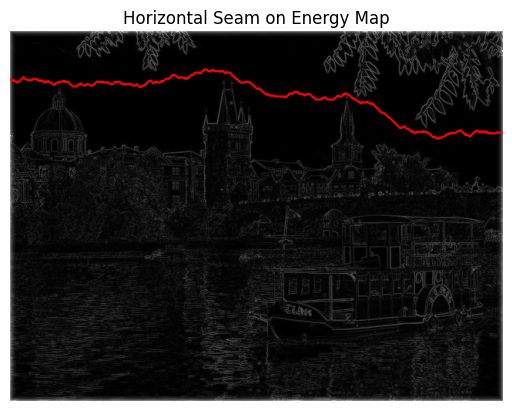

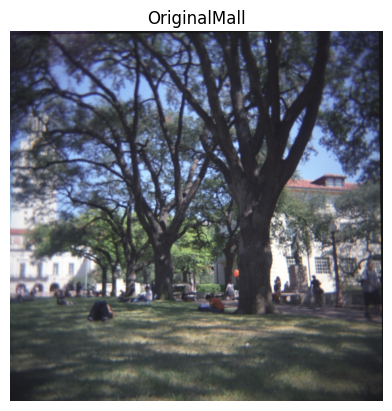

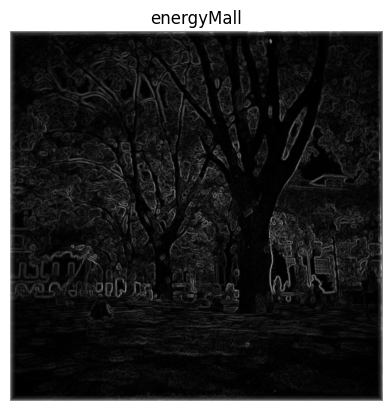

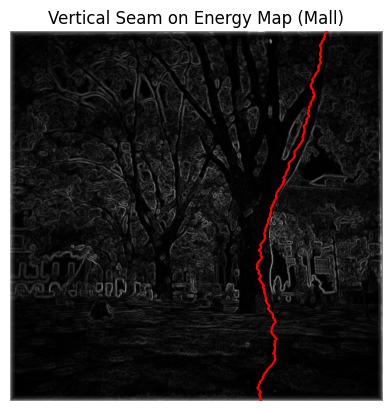

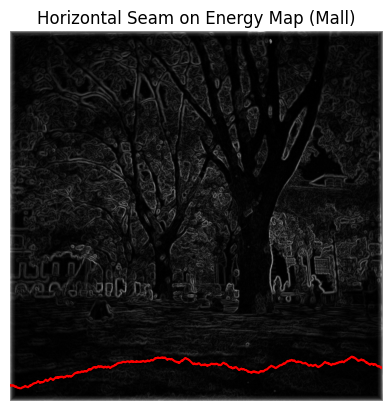

In [27]:
prague = imageio.imread("inputSeamCarvingPrague.jpg") #loading prague using imagio read to store the image
mall = imageio.imread("inputSeamCarvingMall.jpg") #same for mall image

# copy the image into car img
img = prague.copy()
plt.imshow(img); plt.title("OriginalPrague"); plt.axis('off'); plt.show()  #show the base image so we know what we started with

# compute the energy map and view in grey so we can see edges with higher energy and dark loww energy areas
E_prague = find_energy(prague) #save the energy map into E_prague so we can display it
plt.imshow(E_prague, cmap='gray'); plt.title("energyPrague"); plt.axis('off');plt.show()  #plt imshow to display Energy map for prague with title

# build dynamic programming tables for both seam directions like we saw in class and in the pdf
CVertical = Cumulative_min_energy_map(E_prague, "VERTICAL")    #vertical c map
CHorizontal = Cumulative_min_energy_map(E_prague, "HORIZONTAL")  #horizontal c map

# backtrack to get the first optimal seams and store them into Vertical and Horizontal varialbles (one column index per row, one row index per column)
v_seam = find_vertical_seam(CVertical)
h_seam = find_horizontal_seam(CHorizontal)

# overlay the vertical seam ON TOP of the energy map (x=seam cols, y=row indices)
plt.imshow(E_prague, cmap='gray'); plt.title("Vertical Seam on Energy Map"); plt.axis('off'); #display as we have learned to do
plt.plot(v_seam, np.arange(len(v_seam)), 'r-'); plt.show()  #plotting the seams in red line format using plt.plot over the images so we can see vertical seams

# overlay  horizontal usinng vertical transposed
plt.imshow(E_prague, cmap='gray'); plt.title("Horizontal Seam on Energy Map"); plt.axis('off');
plt.plot(np.arange(len(h_seam)), h_seam, 'r-'); plt.show()

# show a seam being carved on the Mall image
# same exact steps but with the mall pic so we can compare behavior
img1 = mall.copy()
plt.imshow(img1); plt.title("OriginalMall"); plt.axis('off'); plt.show()
E_mall = find_energy(mall)
plt.imshow(E_mall, cmap='gray'); plt.title("energyMall"); plt.axis('off');plt.show()

# cumulative maps for mall too (direction matters same as above)
CV_mall = Cumulative_min_energy_map(E_mall, "VERTICAL")    #vertical cumulative map
CH_mall = Cumulative_min_energy_map(E_mall, "HORIZONTAL")  #horizontal cumulative map

# get the first seams for mall
v_seam_mall = find_vertical_seam(CV_mall)
h_seam_mall = find_horizontal_seam(CH_mall)

# plot the vertical seam on mall’s energy so we can sanity check path
plt.imshow(E_mall, cmap='gray'); plt.title("Vertical Seam on Energy Map (Mall)"); plt.axis('off');
plt.plot(v_seam_mall, np.arange(len(v_seam_mall)), 'r-'); plt.show()

# plot the horizontal seam on mall’s energy map too
plt.imshow(E_mall, cmap='gray'); plt.title("Horizontal Seam on Energy Map (Mall)"); plt.axis('off');
plt.plot(np.arange(len(h_seam_mall)), h_seam_mall, 'r-'); plt.show()


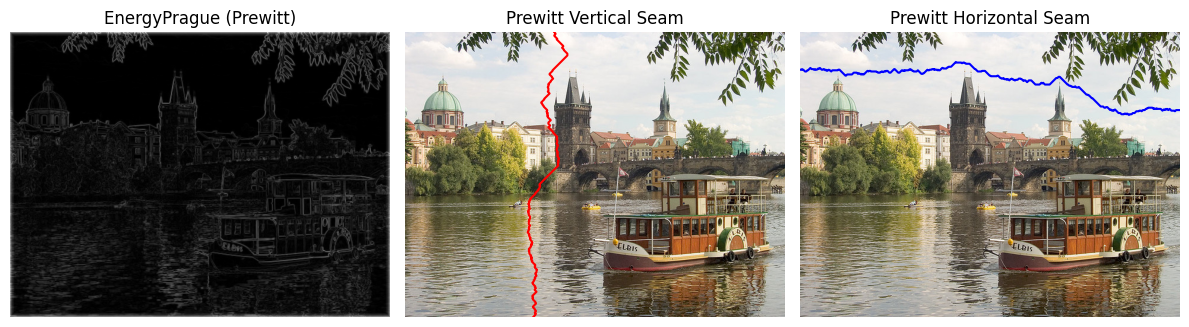

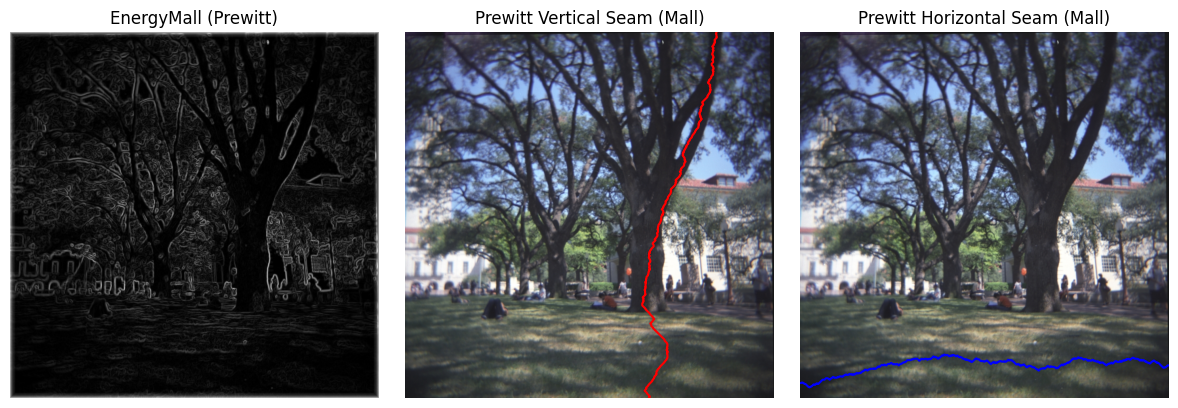

In [28]:

# Calculate energy using Prewitt filter
E_prewitt_prague = find_energy_prewitt(prague)
CV_p = Cumulative_min_energy_map(E_prewitt_prague, "VERTICAL")
CH_p = Cumulative_min_energy_map(E_prewitt_prague, "HORIZONTAL")
v_p = find_vertical_seam(CV_p)
h_p = find_horizontal_seam(CH_p)

# Display Prewitt energy map and seams for Prague
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(E_prewitt_prague, cmap='gray')
plt.title("EnergyPrague (Prewitt)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(prague)
plt.plot(v_p, np.arange(len(v_p)), 'r-')
plt.title("Prewitt Vertical Seam")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prague)
plt.plot(np.arange(len(h_p)), h_p, 'b-')
plt.title("Prewitt Horizontal Seam")
plt.axis('off')
plt.tight_layout()
plt.show()

# Do the same for Mall image
E_prewitt_mall = find_energy_prewitt(mall)
CV_p_mall = Cumulative_min_energy_map(E_prewitt_mall, "VERTICAL")
CH_p_mall = Cumulative_min_energy_map(E_prewitt_mall, "HORIZONTAL")
v_p_mall = find_vertical_seam(CV_p_mall)
h_p_mall = find_horizontal_seam(CH_p_mall)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(E_prewitt_mall, cmap='gray')
plt.title("EnergyMall (Prewitt)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mall)
plt.plot(v_p_mall, np.arange(len(v_p_mall)), 'r-')
plt.title("Prewitt Vertical Seam (Mall)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mall)
plt.plot(np.arange(len(h_p_mall)), h_p_mall, 'b-')
plt.title("Prewitt Horizontal Seam (Mall)")
plt.axis('off')
plt.tight_layout()
plt.show()




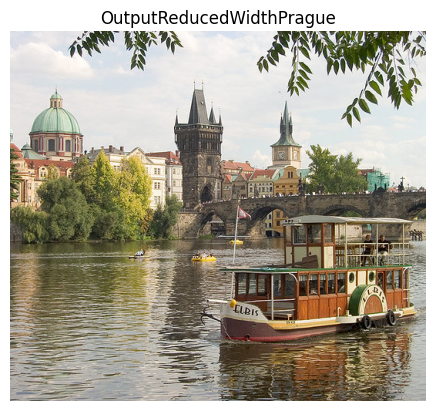

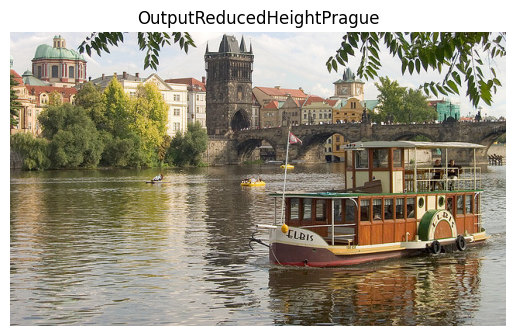

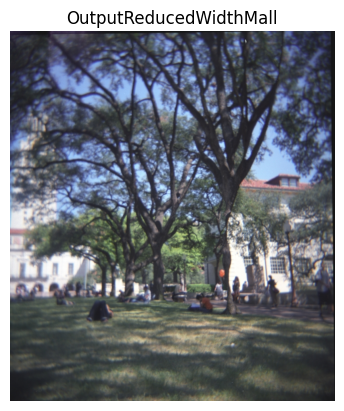

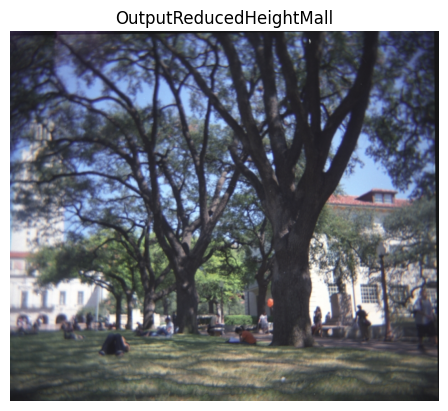

In [29]:
#first we must reduce the width of both or either by 100 pixels
img = prague.copy()
e = find_energy(img)
for _ in range(100):
  img, e = decrease_width(img, e)
imageio.imwrite("OutputReducedWidthPrague.jpg", img)
plt.imshow(img); plt.title("OutputReducedWidthPrague"); plt.axis('off'); plt.show()

img = prague.copy()
e = find_energy(img)
for _ in range(100):
  img, e = decrease_height(img, e)
imageio.imwrite("OutputReducedHeightPrague.jpg", img)
plt.imshow(img); plt.title("OutputReducedHeightPrague"); plt.axis('off'); plt.show()

img = mall.copy()
e = find_energy(img)
for _ in range(100):
  img, e = decrease_width(img, e)
imageio.imwrite("OutputReducedWidthMall.jpg", img)
plt.imshow(img); plt.title("OutputReducedWidthMall");plt.axis('off'); plt.show()

img = mall.copy()
e = find_energy(img)
for _ in range(100):
  img, e = decrease_height(img, e)
imageio.imwrite("OutputReducedHeightMall.jpg", img)
plt.imshow(img); plt.title("OutputReducedHeightMall");plt.axis('off'); plt.show()

=== Task 6: Seam Carving on Custom Images ===
Comparing seam carving vs standard resizing on personal images

seam carving...
seam carving...
seam carving...


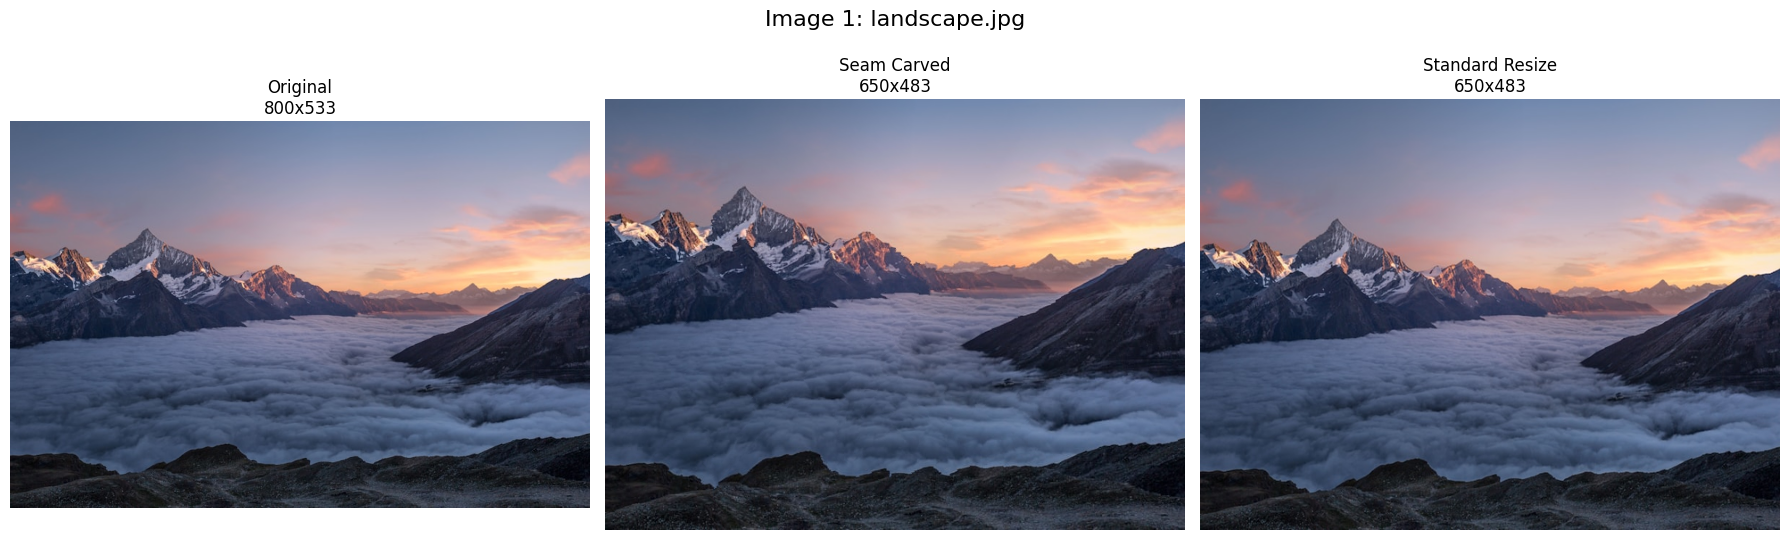

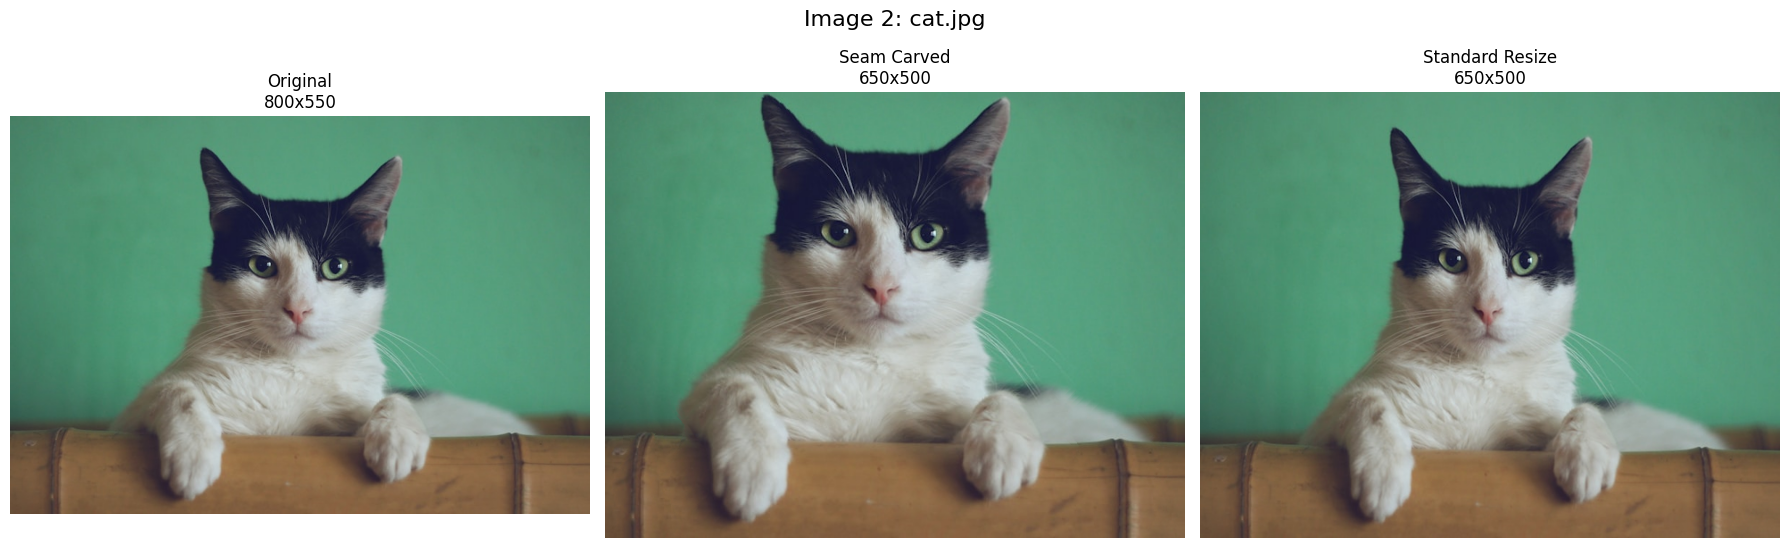

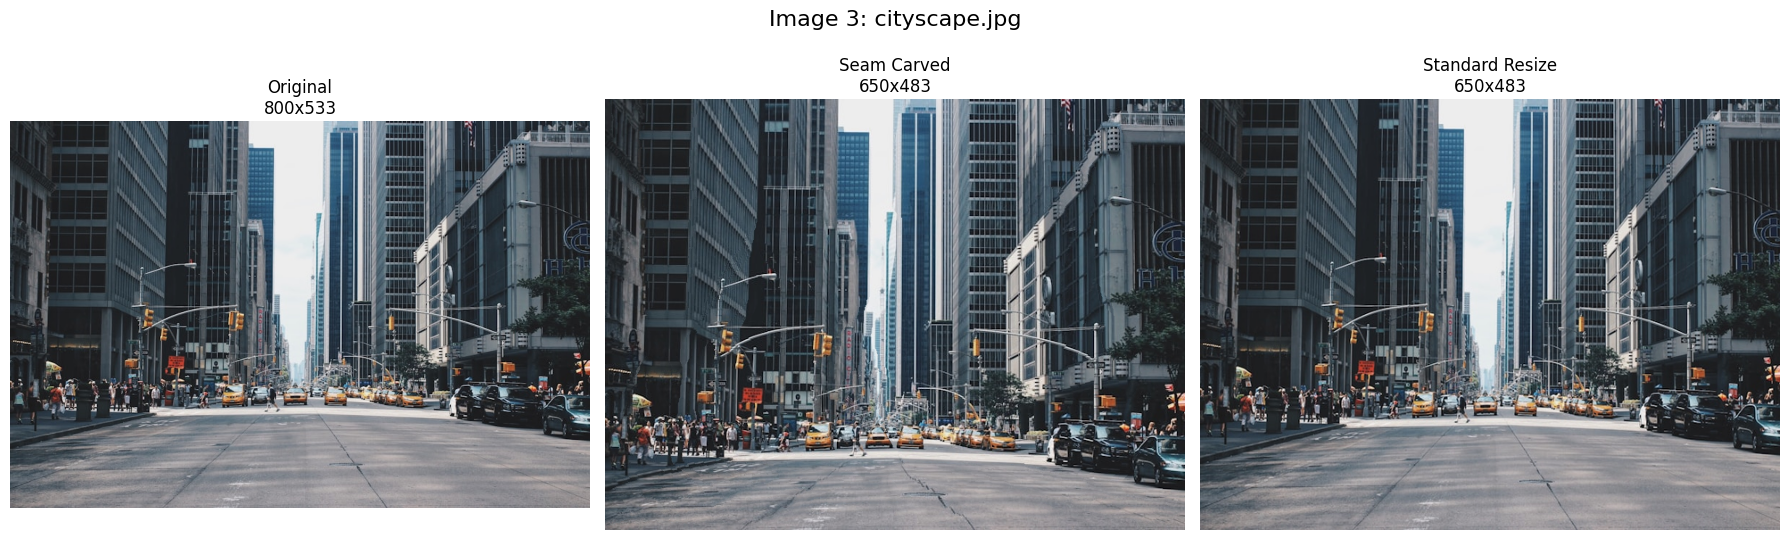

In [30]:
# Task 6 — Experiments on your own images
print("=== Task 6: Seam Carving on Custom Images ===")
print("Comparing seam carving vs standard resizing on personal images\n")



import urllib.request
import os

# Create a directory for test images if it doesn't exist
os.makedirs('test_images', exist_ok=True)

# Example: Download some test images
test_urls = [
    ('https://images.unsplash.com/photo-1506905925346-21bda4d32df4', 'test_images/landscape.jpg'),  # Mountain landscape
    ('https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba', 'test_images/cat.jpg'),       # Cat portrait
    ('https://images.unsplash.com/photo-1449824913935-59a10b8d2000', 'test_images/cityscape.jpg'), # City street
]

# Download test images if they don't exist
for url, filepath in test_urls:
    if not os.path.exists(filepath):
        try:
            urllib.request.urlretrieve(url + '?w=800', filepath)
        except:
            print(f"download faiked: {filepath}")

# Use test images or your own
my_images = ['test_images/landscape.jpg', 'test_images/cat.jpg', 'test_images/cityscape.jpg']

def process_and_compare_image(image_path, width_reduction=100, height_reduction=50):
    """
    Process a single image and compare seam carving vs standard resize.
    """
    # Load image
    img = imageio.imread(image_path)
    if img.ndim == 2:  # Convert grayscale to RGB
        img = np.stack([img, img, img], axis=2)
    
    original_h, original_w = img.shape[:2]
    target_w = original_w - width_reduction
    target_h = original_h - height_reduction
    
    # 1. Seam Carving
    print("seam carving...")
    img_carved = img.copy()
    
    # Remove vertical seams (width reduction)
    if width_reduction > 0:
        e = find_energy(img_carved)
        for i in range(width_reduction):
            img_carved, e = decrease_width(img_carved, e)
    
    # Remove horizontal seams (height reduction)
    if height_reduction > 0:
        e = find_energy(img_carved)
        for i in range(height_reduction):
            img_carved, e = decrease_height(img_carved, e)
    
    # 2. Standard Resize (using PIL)
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((target_w, target_h), Image.LANCZOS)
    img_resized = np.array(img_resized)
    
    return img, img_carved, img_resized

# Process all images
results = []
for img_path in my_images:
    if os.path.exists(img_path):
        try:
            original, carved, resized = process_and_compare_image(img_path, 
                                                                width_reduction=150, 
                                                                height_reduction=50)
            results.append((img_path, original, carved, resized))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Display results
for i, (img_path, original, carved, resized) in enumerate(results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original
    axes[0].imshow(original)
    axes[0].set_title(f'Original\n{original.shape[1]}x{original.shape[0]}')
    axes[0].axis('off')
    
    # Seam Carved
    axes[1].imshow(carved)
    axes[1].set_title(f'Seam Carved\n{carved.shape[1]}x{carved.shape[0]}')
    axes[1].axis('off')
    
    # Standard Resize
    axes[2].imshow(resized)
    axes[2].set_title(f'Standard Resize\n{resized.shape[1]}x{resized.shape[0]}')
    axes[2].axis('off')
    
    plt.suptitle(f'Image {i+1}: {os.path.basename(img_path)}', fontsize=16)
    plt.tight_layout()
    plt.show()
